# Analysis of yellow taxi dataset

In this workbook we will analyse dataset about yellow taxi trips.

Below one can find useful links for original datasets and other resources used in this notebook:


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

First, we will set variables and load data.

In [2]:
path = 'data/'
data_file = 'data/yellow_taxi_data.csv'
maps_file = 'data/long_lat.csv'

In [3]:
data = pd.read_csv(data_file)
maps = pd.read_csv(maps_file)
# coords column was parsed to string during writing to csv. 
# now we get it as list
maps['coords'] = maps['coords'].apply(lambda x: eval(x)) 

# First look at the data

## Data types

In this section we will look at the dataset and try to get some basic informations.
Let's check shape of the dataset.

In [4]:
no_of_rows, no_of_cols = data.shape
columns = data.columns
print(f'Number of rows: {no_of_rows} \nNumber of cols: {no_of_cols}')

Number of rows: 920000 
Number of cols: 18


And now we can see how the dataset looks like.

In [5]:
data.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2.0,2001-01-01T00:01:48.000,2001-01-01T00:15:47.000,1.0,1.35,1.0,N,43,170,2.0,9.0,0.0,0.5,0.0,0.0,0.3,9.8,NaN
1,2.0,2001-01-01T00:01:48.000,2001-01-01T00:15:47.000,1.0,1.35,1.0,N,43,170,2.0,9.0,0.0,0.5,0.0,0.0,0.3,9.8,NaN
2,2.0,2001-01-01T00:02:26.000,2001-01-01T00:04:49.000,1.0,0.36,1.0,N,48,48,2.0,3.5,0.0,0.5,0.0,0.0,0.3,4.3,NaN
3,2.0,2001-01-01T00:02:26.000,2001-01-01T00:04:49.000,1.0,0.36,1.0,N,48,48,2.0,3.5,0.0,0.5,0.0,0.0,0.3,4.3,NaN
4,2.0,2001-01-01T00:05:12.000,2001-01-01T00:09:59.000,1.0,0.62,1.0,N,140,229,2.0,5.0,0.0,0.5,0.0,0.0,0.3,5.8,NaN


Let's print some informations about dataset.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920000 entries, 0 to 919999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   vendorid               919174 non-null  float64
 1   tpep_pickup_datetime   920000 non-null  object 
 2   tpep_dropoff_datetime  920000 non-null  object 
 3   passenger_count        919174 non-null  float64
 4   trip_distance          920000 non-null  float64
 5   ratecodeid             919174 non-null  float64
 6   store_and_fwd_flag     919174 non-null  object 
 7   pulocationid           920000 non-null  int64  
 8   dolocationid           920000 non-null  int64  
 9   payment_type           919174 non-null  float64
 10  fare_amount            920000 non-null  float64
 11  extra                  920000 non-null  float64
 12  mta_tax                920000 non-null  float64
 13  tip_amount             920000 non-null  float64
 14  tolls_amount           920000 non-nu

First of all, last dimension - `congestion_surcharge` is not presented in data from 2018, so we will remove it for data consistency.

In [7]:
del data['congestion_surcharge']

We can see that there are some missing values but not so many raws affected so wi will not perform any replacement and simply remove these rows.

In [8]:
data = data.loc[~data.isna().any(axis=1)]

There are also some issues with data types:
- `tpep_pickup_datetime` and `tpep_dropoff_datetime` should be parse to datetime format
<!-- - `vendorid`, `ratecodeid`, `store_and_fwd_flag`, `pulocationid`, `dolocationid`, `payment_type` are in fact categories not numerical data. -->

We can change above datatypes.

In [9]:
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
data['tpep_dropoff_datetime'] = data['tpep_dropoff_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))

In [10]:
# for c in ['vendorid', 'ratecodeid', 'store_and_fwd_flag', 'payment_type']:
#     data[c] = data[c].astype('category')

We will left `ulocationid`, `dolocationid` unchanged for now - we will use them for merging location data.

## Date ranges

Data should contains only rows for 2018 and 2019, however we can see that it is not the case, for example:

In [11]:
print(f'Minimal datetime: {min(data["tpep_pickup_datetime"])}')

Minimal datetime: 2001-01-01 00:01:48


So we will remove such rows.

In [12]:
data = data.loc[data.tpep_pickup_datetime.dt.year.isin([2018, 2019])]

In [13]:
data = data.loc[data.tpep_dropoff_datetime.dt.year.isin([2018, 2019])]

Now let's create some new column with date / time informations. They might bring useful insight during futher analysis.

In [14]:
data['pickup_day'] = data['tpep_pickup_datetime'].dt.day_name()
data['pickup_date'] = data['tpep_pickup_datetime'].dt.date
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.day_name()
data['dropoff_date'] = data['tpep_dropoff_datetime'].dt.date
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

## Categorical data

Let's quickly go through categorical data. Here we can get rid of classes that should not be presented (according to dataset documentation).

### Vendor id

In [15]:
data['vendorid'].value_counts()

2.0    550087
1.0    363427
4.0      3754
Name: vendorid, dtype: int64

In [16]:
data = data.loc[data['vendorid'].isin([1, 2])]

### Rate code id

In [17]:
data['ratecodeid'].value_counts()

1.0     884803
2.0      22159
5.0       4257
3.0       1581
4.0        682
99.0        24
6.0          8
Name: ratecodeid, dtype: int64

As expceted, most of trips are 'standard' (`ratecodeid=1`). But trips to or from JFK Airport are also popular (`ratecodeid=2`). These trips have fixed fare amount so it is important to get this variable into account.

There are also some wrong values: 99.

In [18]:
data.query('ratecodeid == 2').groupby(by=['ratecodeid', 'fare_amount']).size()

ratecodeid  fare_amount
2.0         -52.00            80
             0.00              2
             2.50              4
             10.50             1
             20.00             2
             52.00         22065
             68.56             1
             73.06             3
             77.86             1
dtype: int64

In [19]:
data = data.loc[data['ratecodeid'].isin([1, 2, 3, 4, 5, 6])]
data = data.loc[~( (data['ratecodeid'] == 2) & (data['fare_amount'] != 52) )]

Let's also convert `ratecodeid` to `sting` as it is a categorical variable.

In [20]:
data['ratecodeid'] = data['ratecodeid'].astype(int).astype(str)

### Store and fwd flag

This feature indicates if data about trip was stored in vehicle memory due to lack on connection with server.

In [21]:
data['store_and_fwd_flag'].value_counts()

N    907412
Y      5984
Name: store_and_fwd_flag, dtype: int64

### Payment type

Most payments were done with credit card (1) or cash (2). In some cases there was no charge or dispute

In [22]:
data['payment_type'].value_counts()

1.0    646559
2.0    260449
3.0      4773
4.0      1615
Name: payment_type, dtype: int64

## Numerical data

Now let's move to numerical columns. In this section we will try to get some informations about numerica columns and remove rows that are outliers.

In [23]:
data.describe()

,vendorid,passenger_count,trip_distance,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_hour,dropoff_hour
count,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000,913396.000000
mean,1.602130,1.590930,2.946103,162.910255,161.148970,1.300899,13.093656,0.651757,0.496658,2.012570,0.348288,0.299256,17.419081,14.441215,14.537821
std,0.489459,1.235206,3.805657,66.181098,70.678102,0.481060,11.938457,0.931009,0.046729,2.714685,1.908940,0.020277,14.713907,6.151961,6.231711
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-400.000000,-3.500000,-0.500000,-88.880000,-18.620000,-0.300000,-320.240000,0.000000,0.000000
25%,1.000000,1.000000,0.980000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,9.360000,10.000000,10.000000
50%,2.000000,1.000000,1.610000,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.560000,0.000000,0.300000,12.960000,16.000000,16.000000
75%,2.000000,2.000000,3.020000,233.000000,233.000000,2.000000,14.500000,1.000000,0.500000,2.660000,0.000000,0.300000,18.960000,20.000000,20.000000
max,2.000000,9.000000,129.280000,265.000000,265.000000,4.000000,950.000000,7.000000,3.300000,400.000000,777.280000,1.000000,996.100000,23.000000,23.000000


We can notice some errors:
- `passenger_count = 0`
- `trip_distance = 0`
- `fare_amount < 0`
- `extra < 0`
- `mta_tax < 0`
- `tip_amount < 0` (Note! Only tips from creditcards - no cash included)
- `tolls_amount < 0`
- `improvement_surcharge < 0`
- `total_amount < 0`

We will remove rows with such values. There are also rows with very high values - we will look at them later on.

In [24]:
query = '''\
passenger_count <= 0 or trip_distance <= 0 or fare_amount < 0 \
or extra < 0 or mta_tax < 0 or tip_amount < 0 or tolls_amount < 0 \
or improvement_surcharge < 0 or total_amount < 0'''

In [25]:
data = data.query(f'~({query})').copy()

Let's see how numerical data looks after removing some faulty rows.

In [26]:
data.describe()

,vendorid,passenger_count,trip_distance,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_hour,dropoff_hour
count,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000,894587.000000
mean,1.610189,1.613103,2.971036,162.870025,161.013346,1.296096,13.025396,0.643167,0.498430,2.006979,0.346011,0.299964,17.347807,14.444212,14.541951
std,0.487708,1.231754,3.814280,66.122044,70.628966,0.472759,11.271676,0.918595,0.028186,2.622147,1.905074,0.003281,14.096948,6.150453,6.230104
min,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,9.360000,10.000000,10.000000
50%,2.000000,1.000000,1.630000,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.560000,0.000000,0.300000,12.960000,16.000000,16.000000
75%,2.000000,2.000000,3.050000,233.000000,233.000000,2.000000,14.500000,1.000000,0.500000,2.660000,0.000000,0.300000,18.960000,20.000000,20.000000
max,2.000000,9.000000,129.280000,265.000000,265.000000,4.000000,426.000000,7.000000,3.300000,331.650000,777.280000,0.300000,996.100000,23.000000,23.000000


Data look much better now but there are still some issues. Let's dig a bit deeper.

### Far amount, total amount and trip distance

We can plot some graphs with `fare_amount` vs `trip_distance` and `fare_amount` vs `total_amount`.

<AxesSubplot:xlabel='total_amount', ylabel='fare_amount'>

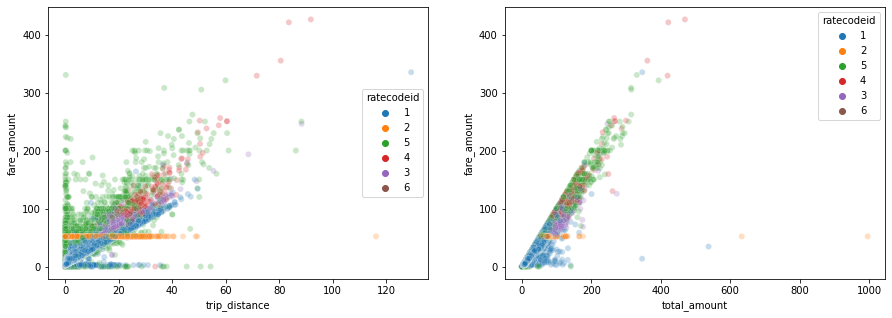

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x='trip_distance', y='fare_amount', data=data, hue = 'ratecodeid', ax=ax[0], alpha=0.25)
sns.scatterplot(x='total_amount', y='fare_amount', data=data, hue = 'ratecodeid', ax=ax[1], alpha=0.25)

There should be positive correlations in above plots. In general it is the case. However, we can see some outliers. On the first plot there ara some clusters. Let's investigate them.

Blue color (`ratecodeid = 1`) indicates standard trips. And with standard trips, correlation between `trip_distance` and `fare_amount` is linear.

Yellow color (`ratecodeid = 2`) indicates trips to/from JFK Airport. These trips have fixed fare amount.

Then comes green color (`ratecodeid = 5`) which stands for negotiated fare. These points are usually placed higher than standard trips: for the same trip distance, fare amount is higher.

We can look at some most extreme poits.

In [28]:
data.query('fare_amount > 290 or trip_distance > 70')

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_date,pickup_hour,dropoff_day,dropoff_date,dropoff_hour
16566,2.0,2018-11-15 08:56:48,2018-11-15 10:59:04,1.0,88.33,3,N,50,265,2.0,246.00,0.0,0.0,0.00,0.00,0.3,246.30,Thursday,2018-11-15,8,Thursday,2018-11-15,10
49349,2.0,2018-12-11 08:17:09,2018-12-11 10:16:41,1.0,80.54,4,N,132,265,1.0,355.00,0.0,0.5,0.00,5.76,0.3,361.56,Tuesday,2018-12-11,8,Tuesday,2018-12-11,10
71402,1.0,2018-12-26 00:02:54,2018-12-26 01:44:24,1.0,86.20,5,N,264,264,1.0,200.00,0.0,0.0,0.00,0.00,0.3,200.30,Wednesday,2018-12-26,0,Wednesday,2018-12-26,1
271768,2.0,2018-05-05 21:34:01,2018-05-05 22:26:36,1.0,50.86,5,N,132,265,1.0,305.00,0.0,0.0,10.10,0.00,0.3,315.40,Saturday,2018-05-05,21,Saturday,2018-05-05,22
294686,2.0,2018-05-15 18:26:16,2018-05-15 18:26:21,1.0,0.20,5,N,264,264,1.0,330.33,0.0,0.5,0.00,0.00,0.3,331.13,Tuesday,2018-05-15,18,Tuesday,2018-05-15,18
299704,2.0,2018-05-18 20:19:53,2018-05-18 23:13:17,3.0,129.28,1,N,48,265,2.0,335.00,0.5,0.5,0.00,10.50,0.3,346.80,Friday,2018-05-18,20,Friday,2018-05-18,23
332756,2.0,2018-06-12 13:19:15,2018-06-12 13:55:36,5.0,116.16,2,N,145,132,2.0,52.00,0.0,0.5,0.00,0.00,0.3,52.80,Tuesday,2018-06-12,13,Tuesday,2018-06-12,13
373280,2.0,2018-07-08 15:05:06,2018-07-08 16:25:06,1.0,71.58,4,N,132,265,1.0,329.00,0.0,0.5,69.96,20.00,0.3,419.76,Sunday,2018-07-08,15,Sunday,2018-07-08,16
403756,2.0,2018-07-27 09:47:28,2018-07-27 11:56:35,1.0,88.30,5,N,132,265,1.0,250.00,0.0,0.5,51.31,5.76,0.3,307.87,Friday,2018-07-27,9,Friday,2018-07-27,11
661265,2.0,2019-04-22 23:20:43,2019-04-23 00:31:29,1.0,59.88,5,N,138,265,1.0,321.00,0.0,0.0,50.00,22.74,0.3,394.04,Monday,2019-04-22,23,Tuesday,2019-04-23,0


Such trips are really rare so we can remove them - it will result in more consistent data.

But before we do that, let's look at outliers from second picture.

In [29]:
data.query('fare_amount < 100 and total_amount > 300')

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_date,pickup_hour,dropoff_day,dropoff_date,dropoff_hour
33117,2.0,2018-11-30 20:36:01,2018-11-30 20:47:29,1.0,3.88,1,N,87,107,1.0,13.5,0.5,0.5,331.65,0.00,0.3,346.45,Friday,2018-11-30,20,Friday,2018-11-30,20
251501,1.0,2018-04-23 10:07:07,2018-04-23 11:01:58,1.0,19.20,2,N,231,132,3.0,52.0,0.0,0.5,166.02,777.28,0.3,996.10,Monday,2018-04-23,10,Monday,2018-04-23,11
838602,1.0,2019-01-25 17:21:05,2019-01-25 18:23:21,1.0,17.50,2,N,264,264,2.0,52.0,4.5,0.5,0.00,576.00,0.3,633.30,Friday,2019-01-25,17,Friday,2019-01-25,18
919509,1.0,2019-02-06 10:11:13,2019-02-06 10:50:52,1.0,10.50,1,N,50,138,3.0,34.5,2.5,0.5,0.00,500.05,0.3,537.85,Wednesday,2019-02-06,10,Wednesday,2019-02-06,10


There are some huge tolls and/or tips. As above, such values are possible but very rare and extreme.

So let's clean the data.

In [30]:
data = data.query('~(fare_amount < 100 and total_amount > 300) and ~(fare_amount > 290 or trip_distance > 70)')

### Passenger count

Let's plot some basic graphs.

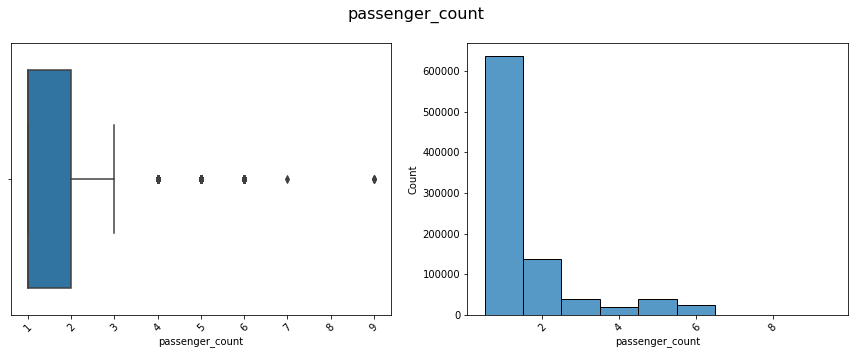

In [34]:
simple_box_plot_and_hisotgram(data, column='passenger_count', figsize=(15, 5), discrete=True, kde=False, bins='auto')

Defintely, one-passenger trips are most popular.

There are some outliers. Let's check them.

In [35]:
data.groupby('passenger_count').size()

passenger_count
1.0    636845
2.0    137071
3.0     38395
4.0     18280
5.0     40138
6.0     23837
7.0         1
9.0         3
dtype: int64

Values above 6 are extremaly rare.

In [36]:
data = data.query('passenger_count <= 6')

## Time

Now it is a time for a time variabels.

First, let's check number of trips per weekday and hour.

In [37]:
data_agg = data.groupby(by = ['pickup_day', 'pickup_hour'], as_index=False).agg(
    number_of_trips = ('fare_amount', 'count'),
    average_fare_amount = ('fare_amount', np.mean),
    total_fare_amount = ('fare_amount', np.sum)
)

Text(0.5, 1.0, 'Total fare amount per hour')

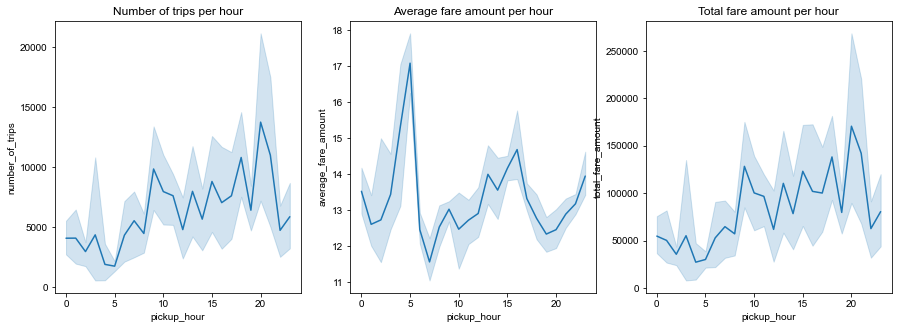

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
sns.set_theme(style="darkgrid")

sns.lineplot(ax=ax[0], x='pickup_hour', y='number_of_trips', data=data_agg)
ax[0].set_title('Number of trips per hour')

sns.lineplot(ax=ax[1], x='pickup_hour', y='average_fare_amount', data=data_agg)
ax[1].set_title('Average fare amount per hour')

sns.lineplot(ax=ax[2], x='pickup_hour', y='total_fare_amount', data=data_agg)
ax[2].set_title('Total fare amount per hour')

We can see that number of trips increases rapidly in the morning (between 5 and 10 a.m.); then it is almost stable and again increases in the afternoon (about 8 p.m.). Plot of total fare amount looks similar. But average fare amount is definitely highest in the morning.

## Loading location data

Now, we can add some informations about locations. File was prepared earlier in the notebook `maps.ipynb`.

In [39]:
maps.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,coords,x,y
0,1,0.116357,0.000782,Newark Airport,1,EWR,"[(933100.9183527103, 192536.08569720192), (933...",9.359210e+05,190798.948561
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"[(1033269.2435912937, 172126.0078125), (103343...",1.034880e+06,162357.340842
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"[(1026308.7695066631, 256767.6975403726), (102...",1.026705e+06,254200.631614
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"[(992073.4667968601, 203714.07598876953), (992...",9.911216e+05,202996.758991
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"[(935843.3104932606, 144283.33585065603), (936...",9.315082e+05,142146.593123


We can join this data with main dataset using `OBJECTID`

First, let's add informations for pick up location.

In [40]:
data = data.merge(maps[['OBJECTID', 'zone', 'borough', 'x', 'y']],
                  how = 'left',
                  left_on = 'pulocationid', right_on = 'OBJECTID',
                  validate = 'm:1')

del data['OBJECTID']
data.rename(columns = {'zone': 'pickup_zone', 'borough': 'pickup_borough', 'x': 'pickup_x', 'y': 'pickup_y'}, inplace=True)

And now for drop off.

In [41]:
data = data.merge(maps[['OBJECTID', 'zone', 'borough', 'x', 'y']],
                  how = 'left',
                  left_on = 'dolocationid', right_on = 'OBJECTID',
                  validate = 'm:1')

del data['OBJECTID']
data.rename(columns = {'zone': 'dropoff_zone', 'borough': 'dropoff_borough', 'x': 'dropoff_x', 'y': 'dropoff_y'}, inplace=True)

We can notice that in some cases location data are not presented. It is due to a fact that in shapefile there are no such locations (for example 264 or 265).

In [42]:
data.loc[data.isna().any(axis=1)].head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_date,pickup_hour,dropoff_day,dropoff_date,dropoff_hour,pickup_zone,pickup_borough,pickup_x,pickup_y,dropoff_zone,dropoff_borough,dropoff_x,dropoff_y
49,2.0,2018-01-01 00:00:51,2018-01-01 00:14:31,1.0,6.63,1,N,264,264,1.0,20.0,0.5,0.5,5.32,0.0,0.3,26.62,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2.0,2018-01-01 00:00:59,2018-01-01 00:02:40,6.0,0.33,1,N,264,264,1.0,3.5,0.5,0.5,0.96,0.0,0.3,5.76,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,2.0,2018-01-01 00:01:07,2018-01-01 00:01:10,2.0,0.06,5,N,264,113,1.0,15.0,0.0,0.0,0.00,0.0,0.3,15.30,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,Greenwich Village North,Manhattan,985856.794349,205930.197075
77,1.0,2018-01-01 00:01:18,2018-01-01 00:10:26,1.0,1.80,1,N,264,264,2.0,8.5,0.5,0.5,0.00,0.0,0.3,9.80,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,1.0,2018-01-01 00:01:26,2018-01-01 00:09:18,1.0,1.00,1,N,264,264,1.0,6.5,0.5,0.5,1.30,0.0,0.3,9.10,Monday,2018-01-01,0,Monday,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Because it is still relatively small part of a dataset we will remove these rows.

In [43]:
data = data.loc[~data.isna().any(axis=1)]

Now we can also get rid off no longer needed features: `pulocationid` and `dolocationid`.

In [44]:
del data['pulocationid']
del data['dolocationid']

We are ready to plot a map of NYC!

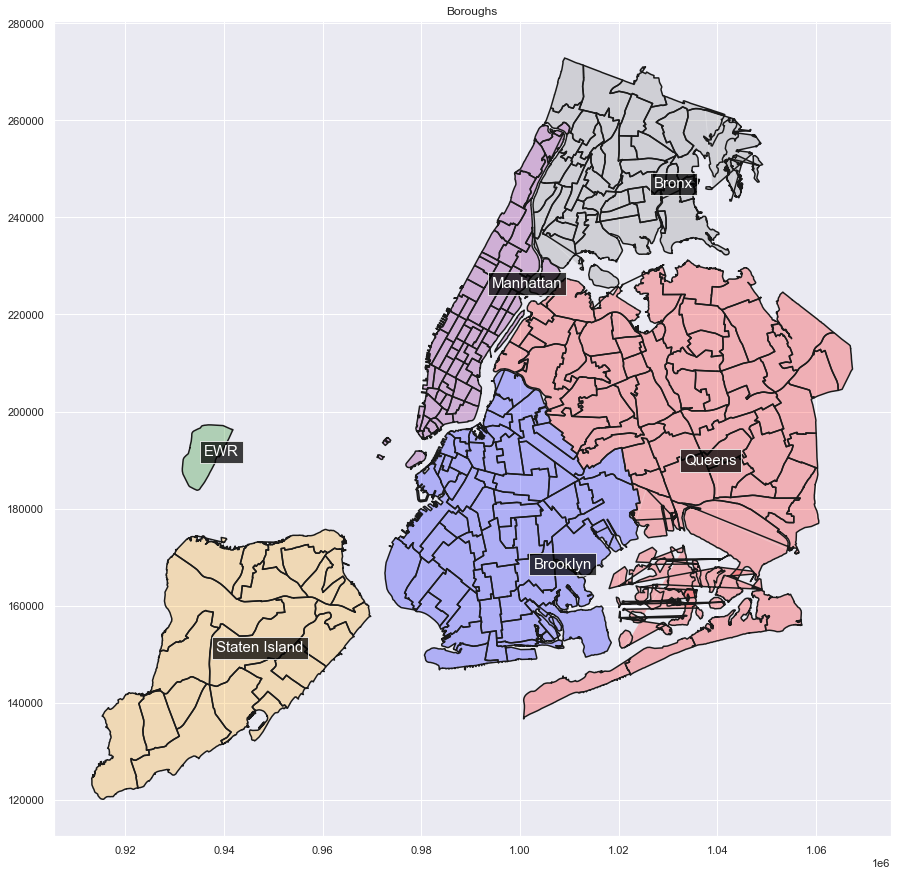

In [45]:
fig, ax = plt.subplots(1, figsize = (15, 15))
borough_map("Boroughs", maps, ax)

## Top trips and top locations

In this section we will try to find out which locations are best: locations with high number of  trips or high fare amounts.

First, let's check best pick up locations. As for now, we will take into account daily fare amount and daily number of trips.

In [46]:
pickup = data.groupby(by=['pickup_date', 'pickup_borough'], as_index=False).agg(
    daily_fare_amount=('fare_amount', np.sum),
    daily_trips=('fare_amount', 'count')
)

pickup = pickup.groupby(by=['pickup_borough'], as_index=False).agg(
    average_daily_fare_amount=('daily_fare_amount', np.mean),
    average_daily_trips=('daily_trips', np.mean)
)
pickup['average_daily_fare_amount_by_trip'] = pickup['average_daily_fare_amount'] / pickup['average_daily_trips']



dropoff = data.groupby(by=['dropoff_date', 'dropoff_borough'], as_index=False).agg(
    daily_fare_amount=('fare_amount', np.sum),
    daily_trips=('fare_amount', 'count')
)

dropoff = dropoff.groupby(by=['dropoff_borough'], as_index=False).agg(
    average_daily_fare_amount=('daily_fare_amount', np.mean),
    average_daily_trips=('daily_trips', np.mean)
)
dropoff['average_daily_fare_amount_by_trip'] = dropoff['average_daily_fare_amount'] / dropoff['average_daily_trips']

Finaly let's plot out data!

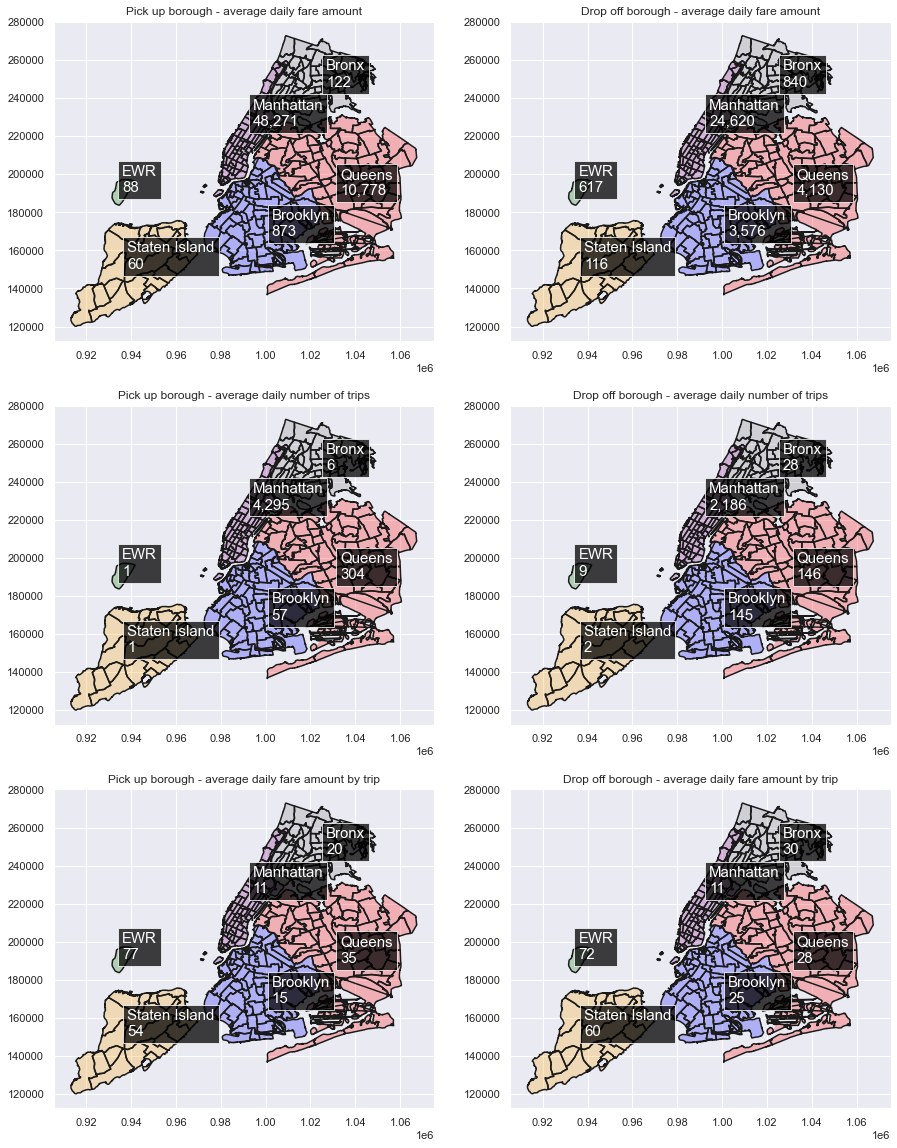

In [47]:
fig, ax = plt.subplots(3, 2, figsize = (15, 20))

borough_map("Pick up borough - average daily fare amount", 
            df = maps, 
            ax = ax[0, 0], 
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in pickup[['pickup_borough', 'average_daily_fare_amount']].itertuples()})

borough_map("Pick up borough - average daily number of trips", 
            df = maps, 
            ax = ax[1, 0],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in pickup[['pickup_borough', 'average_daily_trips']].itertuples()})

borough_map("Pick up borough - average daily fare amount by trip", 
            df = maps, 
            ax = ax[2, 0],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in pickup[['pickup_borough', 'average_daily_fare_amount_by_trip']].itertuples()})



borough_map("Drop off borough - average daily fare amount", 
            df = maps,
            ax = ax[0, 1],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in dropoff[['dropoff_borough', 'average_daily_fare_amount']].itertuples()})

borough_map("Drop off borough - average daily number of trips", 
            df = maps,
            ax = ax[1, 1],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in dropoff[['dropoff_borough', 'average_daily_trips']].itertuples()})

borough_map("Drop off borough - average daily fare amount by trip", 
            df = maps,
            ax = ax[2, 1],
            labels={f'{x[1]}': "{:,.0f}".format(x[2]) for x in dropoff[['dropoff_borough', 'average_daily_fare_amount_by_trip']].itertuples()})

plt.show()

These maps indicates that greatest traffic is in Manhattan. Daily number of trips - in average - is much higher than in next borough which is Queens. As a result, also highest daily fare amount can be observed in Manhattan. 

However, it is not the case in terms of average fare amount for a trip! 

Data for State Island, EWR and Bronx are not really representative - there are not enough data points.

But comparison of Manhattan and Queens indicates that there are much more trips in Manhattan but average fare amount is much higher in Queens.

## Best pick up location and time

Let's add one more variable to out dataset. It will be fare amount by one mile of a trip. It will get some more informations about best trips.

In [48]:
data['fare_amount_by_mile'] = data['fare_amount'] / data['trip_distance']

Let's see a distribution of a new variable.

And now we can select rows that are over median of `fare_amount_by_mile`. 

Then we can count number of trips and average fare amount by zone, weekday and hour.

In [49]:
# median_number_of_trips = data.groupby(by = ['pickup_hour', 'pickup_zone', 'pickup_day'], as_index=False).size()

In [50]:
# simple_box_plot_and_hisotgram(median_number_of_trips.query('size>=10'), column='size', figsize=(15, 5), discrete=False, kde=True, bins='auto')

In [51]:
data_agg = data.loc[data['fare_amount_by_mile'] > data['fare_amount_by_mile'].quantile(0.75), :]
data_agg = data_agg.groupby(by = ['pickup_hour', 'pickup_zone', 'pickup_day'], as_index=False).agg(
    number_of_trips = ('fare_amount', 'count'),
    median_fare_amount = ('fare_amount', np.median)
)

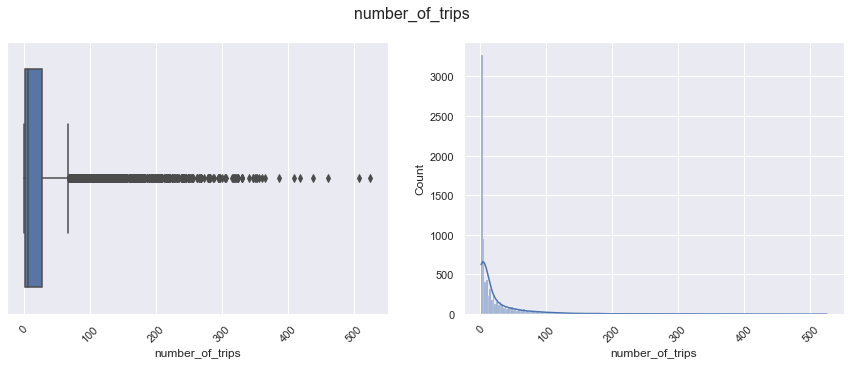

In [52]:
simple_box_plot_and_hisotgram(data_agg, column='number_of_trips', figsize=(15, 5), discrete=False, kde=True, bins='auto')

We can see that there is a large peak at the begining of the histogram. It's probably because some 'good' trips can happen in rare location / time.

So let's select location / time interections that are a bit more common. For example, interections that occured at least 50 times in dataset.

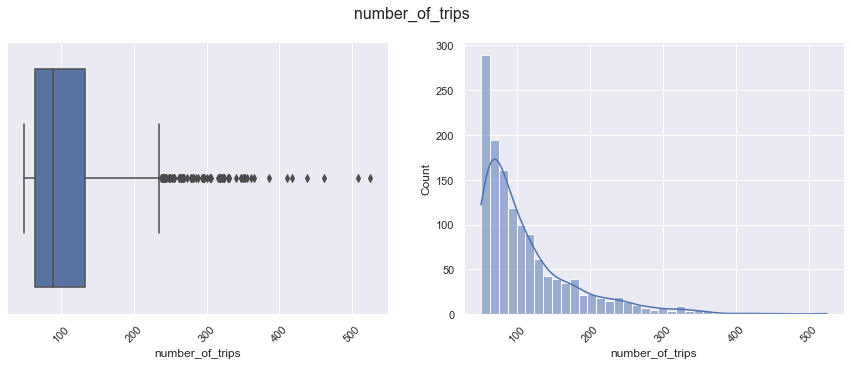

In [53]:
data_agg = data_agg.query('number_of_trips >= 50')
simple_box_plot_and_hisotgram(data_agg, column='number_of_trips', figsize=(15, 5), discrete=False, kde=True, bins='auto')

It looks better now.

In [54]:
data_agg.sort_values(by='number_of_trips', ascending=False).head(10)

,pickup_hour,pickup_zone,pickup_day,number_of_trips,median_fare_amount
3869,13,Midtown Center,Tuesday,525,10.00
3981,13,Upper East Side South,Tuesday,508,7.50
2461,9,Upper East Side South,Thursday,461,7.50
3868,13,Midtown Center,Thursday,438,9.00
3980,13,Upper East Side South,Thursday,418,8.00
7012,20,Midtown Center,Friday,410,7.00
3976,13,Upper East Side North,Tuesday,386,6.25
3298,11,Upper East Side South,Wednesday,365,7.50
2868,10,Upper East Side South,Wednesday,361,6.50
2791,10,Penn Station/Madison Sq West,Wednesday,356,11.00


In [55]:
data_agg.sort_values(by='median_fare_amount', ascending=False).head(10)

,pickup_hour,pickup_zone,pickup_day,number_of_trips,median_fare_amount
3909,13,Penn Station/Madison Sq West,Friday,73,13.50
3319,11,West Chelsea/Hudson Yards,Wednesday,80,12.75
3005,11,East Chelsea,Wednesday,123,12.00
3548,12,Penn Station/Madison Sq West,Tuesday,210,11.75
55,0,Clinton East,Monday,72,11.50
4707,15,Upper West Side North,Wednesday,91,11.50
3211,11,Penn Station/Madison Sq West,Thursday,205,11.50
3913,13,Penn Station/Madison Sq West,Tuesday,268,11.50
3912,13,Penn Station/Madison Sq West,Thursday,232,11.50
3870,13,Midtown East,Friday,94,11.50


Text(0.5, 1.0, '')

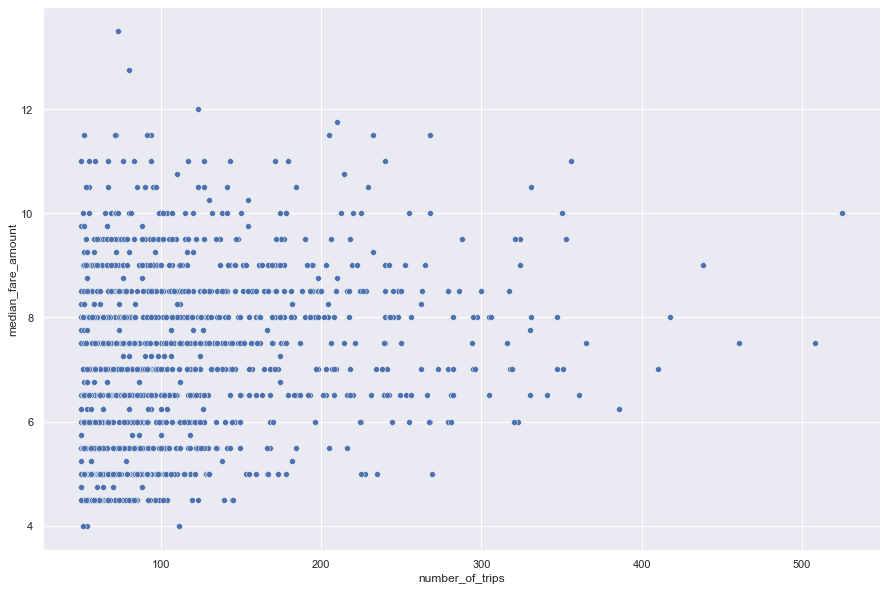

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10))
sns.set_theme(style="darkgrid")

sns.scatterplot(ax=ax, x='number_of_trips', y='median_fare_amount', data=data_agg)
ax.set_title('')

# Predicting `fare_amount`

We will try to build models to predict `fare_amount` on the basis of pickup location and time.

First we will change categorical data into numerical using one-hot encoder.

Then we will remove outliers. As for now we tried to look into a data and remove outliers manually. But before modeling we will perform some multi-dimensional outliers detection.
We will use Isolation Forest algorithm. It can be easly applied to high-dimentinal data.

Next step is spliiting data into train and test sets and standarization.

Finally we will check errors in predictions.

## Data preparation

Let's define predicators.

In [57]:
Y = 'fare_amount'
X_numerical = ['pickup_hour', 'pickup_x', 'pickup_y', 'fare_amount_by_mile']
X_categorical = ['ratecodeid', 'pickup_day', 'pickup_zone', 'pickup_borough']

In [58]:
X = data[[Y] + X_numerical + X_categorical].copy()

### One-hot encoding for categorical data

We have to convert catgeorical data to numerical. We will use one-hot encoder.

In [59]:
X.head()

,fare_amount,pickup_hour,pickup_x,pickup_y,fare_amount_by_mile,ratecodeid,pickup_day,pickup_zone,pickup_borough
0,27.0,0,9.941451e+05,214631.345101,2.954048,1,Monday,Sutton Place/Turtle Bay North,Manhattan
1,7.5,0,9.840966e+05,211884.539346,5.514706,1,Monday,East Chelsea,Manhattan
2,20.5,0,9.948744e+05,201467.320414,3.360656,1,Monday,Williamsburg (North Side),Brooklyn
3,5.5,0,9.961204e+05,223550.620290,5.555556,1,Monday,Upper East Side North,Manhattan
4,13.5,0,1.005347e+06,192662.343965,3.750000,1,Monday,Bushwick South,Brooklyn


In [60]:
X = pd.get_dummies(X)

In [61]:
X.head()

,fare_amount,pickup_hour,pickup_x,pickup_y,fare_amount_by_mile,ratecodeid_1,ratecodeid_2,ratecodeid_3,ratecodeid_4,ratecodeid_5,ratecodeid_6,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_zone_Allerton/Pelham Gardens,pickup_zone_Alphabet City,pickup_zone_Arden Heights,pickup_zone_Arrochar/Fort Wadsworth,pickup_zone_Astoria,pickup_zone_Astoria Park,pickup_zone_Auburndale,pickup_zone_Baisley Park,pickup_zone_Bath Beach,pickup_zone_Battery Park,pickup_zone_Battery Park City,pickup_zone_Bay Ridge,pickup_zone_Bay Terrace/Fort Totten,pickup_zone_Bayside,pickup_zone_Bedford,pickup_zone_Bedford Park,pickup_zone_Bellerose,pickup_zone_Belmont,pickup_zone_Bensonhurst East,pickup_zone_Bensonhurst West,pickup_zone_Bloomfield/Emerson Hill,pickup_zone_Bloomingdale,pickup_zone_Boerum Hill,pickup_zone_Borough Park,pickup_zone_Breezy Point/Fort Tilden/Riis Beach,pickup_zone_Briarwood/Jamaica Hills,pickup_zone_Brighton Beach,pickup_zone_Broad Channel,pickup_zone_Bronx Park,pickup_zone_Bronxdale,pickup_zone_Brooklyn Heights,pickup_zone_Brooklyn Navy Yard,pickup_zone_Brownsville,pickup_zone_Bushwick North,pickup_zone_Bushwick South,pickup_zone_Cambria Heights,pickup_zone_Canarsie,pickup_zone_Carroll Gardens,pickup_zone_Central Harlem,pickup_zone_Central Harlem North,pickup_zone_Central Park,pickup_zone_Chinatown,pickup_zone_Claremont/Bathgate,pickup_zone_Clinton East,pickup_zone_Clinton Hill,pickup_zone_Clinton West,pickup_zone_Co-Op City,pickup_zone_Cobble Hill,pickup_zone_College Point,pickup_zone_Columbia Street,pickup_zone_Coney Island,pickup_zone_Corona,pickup_zone_Crotona Park,pickup_zone_Crotona Park East,pickup_zone_Crown Heights North,pickup_zone_Crown Heights South,pickup_zone_Cypress Hills,pickup_zone_DUMBO/Vinegar Hill,pickup_zone_Douglaston,pickup_zone_Downtown Brooklyn/MetroTech,pickup_zone_Dyker Heights,pickup_zone_East Chelsea,pickup_zone_East Concourse/Concourse Village,pickup_zone_East Elmhurst,pickup_zone_East Flatbush/Farragut,pickup_zone_East Flatbush/Remsen Village,pickup_zone_East Flushing,pickup_zone_East Harlem North,pickup_zone_East Harlem South,pickup_zone_East New York,pickup_zone_East New York/Pennsylvania Avenue,pickup_zone_East Tremont,pickup_zone_East Village,pickup_zone_East Williamsburg,pickup_zone_Eastchester,pickup_zone_Elmhurst,pickup_zone_Elmhurst/Maspeth,pickup_zone_Eltingville/Annadale/Prince's Bay,pickup_zone_Erasmus,pickup_zone_Far Rockaway,pickup_zone_Financial District North,pickup_zone_Financial District South,pickup_zone_Flatbush/Ditmas Park,pickup_zone_Flatiron,pickup_zone_Flatlands,pickup_zone_Flushing,pickup_zone_Flushing Meadows-Corona Park,pickup_zone_Fordham South,pickup_zone_Forest Hills,pickup_zone_Forest Park/Highland Park,pickup_zone_Fort Greene,pickup_zone_Fresh Meadows,pickup_zone_Freshkills Park,pickup_zone_Garment District,pickup_zone_Glen Oaks,pickup_zone_Glendale,pickup_zone_Governor's Island/Ellis Island/Liberty Island,pickup_zone_Gowanus,pickup_zone_Gramercy,pickup_zone_Gravesend,pickup_zone_Green-Wood Cemetery,pickup_zone_Greenpoint,pickup_zone_Greenwich Village North,pickup_zone_Greenwich Village South,pickup_zone_Hamilton Heights,pickup_zone_Hammels/Arverne,pickup_zone_Heartland Village/Todt Hill,pickup_zone_Highbridge,pickup_zone_Highbridge Park,pickup_zone_Hillcrest/Pomonok,pickup_zone_Hollis,pickup_zone_Homecrest,pickup_zone_Howard Beach,pickup_zone_Hudson Sq,pickup_zone_Hunts Point,pickup_zone_Inwood,pickup_zone_Inwood Hill Park,pickup_zone_JFK Airport,pickup_zone_Jackson Heights,pickup_zone_Jamaica,pickup_zone_Jamaica Bay,pickup_zone_Jamaica Estates,pickup_zone_Kensington,pickup_zone_Kew Gardens,pickup_zone_Kew Gardens Hills,pickup_zone_Kingsbridge Heights,pickup_zone_Kips Bay,pickup_zone_LaGuardia Airport,pickup_zone_Laurelton,pickup_zone_Lenox Hill East,pickup_zone_Lenox Hill West,pickup_zone_Lincoln Square East,pickup_zone_Lincoln Square West,pickup_zone_Little Italy/NoLiTa,pickup_

### IsolationForest for outliers detection

In [62]:
# from sklearn.ensemble import IsolationForest

In [63]:
# isolation_forest_model = IsolationForest(random_state=44).fit(X)

In [64]:
# X_outliers = isolation_forest_model.predict(X)

In [65]:
# sum(X_outliers==-1)

No outliers were detected. We will left data unchanged.

### Splitting data into train and test sets

We will split the data into two sets. 2/3 will be for learning and 1/3 for testing.

We will use `sklearn` package.

In [66]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

Let's define feature columns.

In [67]:
features = list(X.columns)
features.remove(Y)

And now we can split our dataset.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X[features], X[Y], test_size=0.33, random_state=44)

In [73]:
print('Training set:', X_train.shape)
print('Training labels:', y_train.shape)
print('Testing set:', X_test.shape)
print('Testing labels:', y_test.shape)

Training set: (590337, 268)
Training labels: (590337,)
Testing set: (290763, 268)
Testing labels: (290763,)


### Data standarization

Let's standarize our data. Again we will use `sklearn` package. First, we will fit scaler to train data and then apply it to train and test sets.

In [74]:
scaler = preprocessing.RobustScaler().fit(X_train)

In [75]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Models

Our data are prepared to build some models. We will try to build two of them:
- random forest from `sklearn`
- neural network from `tensorflow`

#### Random forest

In [76]:
from sklearn.ensemble import RandomForestRegressor

Let's define and fit random forest. Then we can make prediction on test set.

In [77]:
# from sklearn.model_selection import GridSearchCV

# n_estimators = [100, 200]
# max_features = ['auto', 'sqrt']
# max_depth = [10, 25]

# grid_search_params = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth}

In [78]:
# random_forest_model = RandomForestRegressor()
# grid_search = RandomizedSearchCV(estimator=random_forest_model, 
#                                  param_distributions=grid_search_params,
#                                  scoring='neg_mean_absolute_error'
#                                  cv=3, 
#                                  verbose=2,
#                                  random_state=44)
# grid_search.fit(X_train, y_train)

In [79]:
# grid_search.best_params_

In [80]:
# random_forest_best = grid_search.best_estimator_
# random_forest_mae = evaluate(random_forest_best, X_test, y_test)

In [ ]:
# %%time
# rf_model = RandomForestRegressor(n_estimators=150, criterion='mae', max_depth=20, random_state=44)
rf_model = RandomForestRegressor(n_estimators=5, criterion='mae', max_depth=20, random_state=44)
rf_model.fit(X_train, y_train)

In [ ]:
predictions = rf_model.predict(X_test)

In [ ]:
random_forest_mae = evaluate(rf_model, X_test, y_test)
print(f'Random forest MAE: {random_forest_mae}')

In [131]:
print(f'MSE: {mean_squared_error(np.array(y_test), predictions)}')
print(f'MAE: {mean_absolute_error(np.array(y_test), predictions)}')

MSE: 48.893589201184994
MAE: 4.754564270965623


#### Neural network

In [179]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [180]:
nn_model = tf.keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=(len(features), )),
    layers.Dropout(.1),
    layers.Dense(50, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(25, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(5, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])

In [181]:
nn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               26900     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 25)                1275      
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 5)                

In [186]:
metrics = ['mae']
loss = ['mae']
optimizer = 'adagrad'

epochs = 10
batch_size = 32
validation_split = .2

In [187]:
nn_model.compile(
    metrics = metrics,
    optimizer=optimizer,
    loss=loss)

In [188]:
%%time
history = nn_model.fit(
    X_train, 
    y_train,
    epochs=epochs,
    # Calculate validation results on 20% of the training data
    validation_split = validation_split)


Epoch 1/10
14759/14759 [==============================] - 40s 3ms/step - loss: 12.7914 - mae: 12.7914 - val_loss: 12.6266 - val_mae: 12.6266
Epoch 2/10
14759/14759 [==============================] - 36s 2ms/step - loss: 12.6177 - mae: 12.6177 - val_loss: 12.5261 - val_mae: 12.5261
Epoch 3/10
14759/14759 [==============================] - 35s 2ms/step - loss: 12.5304 - mae: 12.5304 - val_loss: 12.4494 - val_mae: 12.4494
Epoch 4/10
14759/14759 [==============================] - 35s 2ms/step - loss: 12.4439 - mae: 12.4439 - val_loss: 12.3842 - val_mae: 12.3842
Epoch 5/10
14759/14759 [==============================] - 36s 2ms/step - loss: 12.3865 - mae: 12.3865 - val_loss: 12.3267 - val_mae: 12.3267
Epoch 6/10
14759/14759 [==============================] - 35s 2ms/step - loss: 12.3357 - mae: 12.3357 - val_loss: 12.2748 - val_mae: 12.2748
Epoch 7/10
14759/14759 [==============================] - 35s 2ms/step - loss: 12.3164 - mae: 12.3164 - val_loss: 12.2277 - val_mae: 12.2277
Epoch 8/10
14

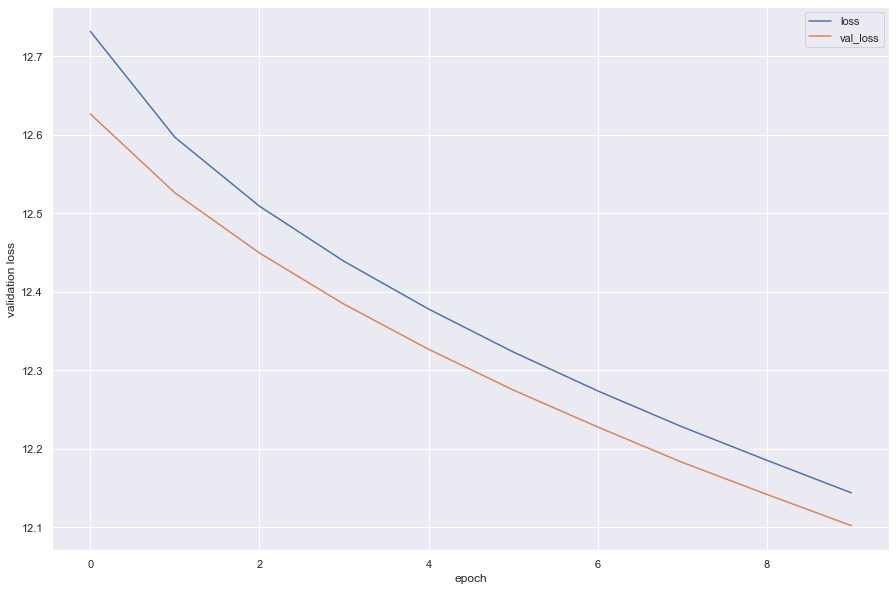

In [198]:
plot_loss(history)

In [174]:
predictions = nn_model.predict(X_test)

In [177]:
def plot_prediction_error(y_test, predictions):
    error = predictions - y_test
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    sns.residplot(x=y_test, y=predictions, lowess=True, color="g")

In [197]:
def plot_loss(history):
    fig, ax = plt.subplots(1, 1, figsize = (15, 10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
#     plt.ylim([0, 10])
    plt.xlabel('epoch')
    plt.ylabel('validation loss')
    plt.legend()
    plt.grid(True)

In [32]:
def borough_map(title, df, ax,
                x_lim = None, 
                y_lim = None, 
                show_labels=True,
                labels=None):
    '''
    Plot map with lim coordinates
    '''
    
    borough_ids = {f'{borough}': list(df.loc[df.borough == borough].index) for borough in df['borough'].unique()}
    borough_colors = {'EWR': 'green', 
                      'Queens': 'red', 
                      'Bronx': 'grey', 
                      'Manhattan': 'purple', 
                      'Staten Island': 'orange', 
                      'Brooklyn': 'blue'}
    
   
    for coord in df['coords']:
        x = [i[0] for i in coord]
        y = [i[1] for i in coord]
        ax.plot(x, y, 'k')
    
    for borough_name, zone_ids in borough_ids.items():
        coords = df.loc[df['borough'] == borough_name, 'coords']
        coords = list(itertools.chain.from_iterable(coords))
        
        for zone_id in zone_ids:
            coord = df.loc[zone_id, 'coords']
            x_lon = [i[0] for i in coord]
            y_lat = [i[1] for i in coord]
            ax.fill(x_lon,y_lat, borough_colors[borough_name], alpha=0.25)
            
        x0 = np.mean([c[0] for c in coords])
        y0 = np.mean([c[1] for c in coords])
        if show_labels:
            if labels is not None and labels.get(borough_name) is not None:
                text = borough_name + f'\n{labels.get(borough_name)}'
            else:
                text = borough_name
            ax.text(x0, y0, text, bbox=dict(facecolor='black', alpha=0.75), color="white", fontsize=15)
    
    if (x_lim != None) & (y_lim != None):     
        ax.xlim(x_lim)
        ax.ylim(y_lim)
        
    ax.set_title(title)

In [33]:
def simple_box_plot_and_hisotgram(data, column, figsize=(15, 5), 
                                  discrete=False,
                                  kde=True,
                                  bins='auto'):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    sns.boxplot(ax=axs[0], x=column, data=data)
    sns.histplot(ax=axs[1], x=column, data=data, discrete=discrete, kde=kde)

    axs[0].tick_params(axis='x', labelrotation=45)
    axs[1].tick_params(axis='x', labelrotation=45)
    
    fig.suptitle(column, fontsize=16)
    plt.show()

    return None